In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
# %matplotlib inline  # if you are running this code in Jupyter notebook

from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

from skimage import data, transform, util
from sklearn.linear_model import LinearRegression

In [1]:
def imshow(*args):
    img_len = len(args)
    fig, axes = plt.subplots(1, img_len, figsize=(16, 8))
    
    if not isinstance(axes, list):
        axes = [axes]
    for ax, img in zip(axes, args):
        ax.imshow(img)
    
    plt.show()

In [3]:
vidcap = cv2.VideoCapture('data/video.MOV')
success,image = vidcap.read()
count = 0
while success:
    cv2.imwrite(f"frame{count}.jpg", image)     # save frame as JPEG file      
    success,image = vidcap.read()
    print('Read a new frame: ', success)
    count += 1
    break

In [3]:
input_images = []
for i in range(1, 10):
    img = cv2.imread(f'data/{i}.PNG')
    input_images.append(img)

## Чтение маски

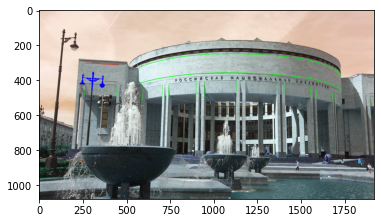

In [876]:
img_source_mask = cv2.imread('frame0-mask.png')
plt.imshow(img_source_mask, cmap='gray')

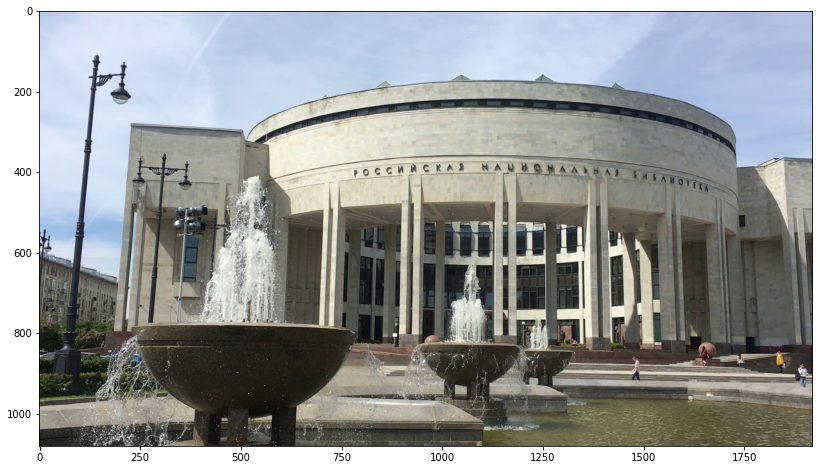

In [342]:
img_source = cv2.imread('frame0.jpg')
img_work = img_source.copy()

# cv2.polylines(img_source, np.array(points_list), True, (0, 0, 255), 5)
_, ax = plt.subplots(1, 1, figsize=(14, 8))
ax.imshow(cv2.cvtColor(img_source, cv2.COLOR_RGB2BGR))

## Поиск вертикальных линий по маске

In [822]:
threshold = 100

def interp(line, min_p, max_p, border=None):
    m = LinearRegression().fit(line[:, 0].reshape((line.shape[0], 1)), line[:, 1])
    if border is None or abs(m.coef_[0]) < border:  # 0.2 по умолчанию для вертикальных линий
        rows = np.arange(min_p, max_p)
        cols = m.predict(rows.reshape((rows.shape[0], 1)))
        
        return np.vstack((rows, cols)).T.astype('int32')
    
    return None

def approximate_lines(lines):
    lines_out = []
    for line_info in lines:
        if len(line_info['line']) < 5:
            continue

        line = np.array(line_info['line'])
        line = interp(line, min_p=1, max_p=line[:, 0].max(), border=0.2) 
        
        if line is not None:
            lines_out.append(line)

    return lines_out

def add_points_to_lines(lines, points: list, row, shift=1):
    for p in points:
        lines_filtered = list(filter(lambda l: l['border'][0] <= p <= l['border'][1], lines))

        if not lines_filtered:
            lines.append({'border': (p - shift, p + shift), 'line': [(row, p)]})
        else:
            if len(lines_filtered) > 1:  # дошли до дуги
                lines_filtered = sorted(lines_filtered, key=lambda l: -len(l['line']))
            
            line_info = lines_filtered[0]
            if line_info['line'][-1][0] - row < 2:
                line_info['line'].append((row, p))

                border = line_info['border']
                line_info['border'] = (min(p - shift, border[0]), max(p + shift, border[1]))  # обновить границы
    
    return lines

def lines_get_splits(array, threshold=100, i=None):
    indices = np.where(array > threshold)[0]
    
    if indices.shape[0] == 1:
        return indices

    elif indices.shape[0] > 1:
        diff, splits = np.diff(indices), []

#         if i == 1886:
#             print(diff)
            
        if (diff > 5).any():
            split_indices = np.where(diff > 5)[0] + 1
            splits = np.split(indices, split_indices)
        else:
            splits = [indices]

        splits = list(map(lambda v: int(v.mean()), splits))
        
        return splits

    return None

def find_vertical_lines(img_source_mask):
    green_mask = (img_source_mask[:, :, 1] > 240) & (img_source_mask[:, :, 0] < 10)
    green_mask = green_mask.astype('uint8') * 255
    
    lines = []  # (border [left, right], line)

    for i, row in enumerate(range(green_mask.shape[0] - 1, 0, -1)):
        img_row = green_mask[row, :]
        
        splits = lines_get_splits(img_row, threshold=threshold)
        if splits is not None:
            lines = add_points_to_lines(lines, splits, row)

    lines = approximate_lines(lines)  # list(np.array([row, col]))
    return sorted(lines, key=lambda l: l[0][1])

lines_v = find_vertical_lines(img_source_mask)
len(lines_v)

17

## Найти горизонтальные линии для левого и правого изображения (синий)

In [899]:
def add_h_points_to_lines(lines, points: list, col, shift=1):
#     if col == 1886:
#         print(points)
    for row in points:
        lines_filtered = list(filter(lambda l: l[-1][0] - shift <= row <= l[-1][0] + shift, lines))
#         print(lines_filtered)

        if not lines_filtered:
            lines.append([(row, col)])
        else:
            if len(lines_filtered) > 1:  # Линии на одних и тех же строках
                # Фильтруем, чтобы первая запись была правее всего
                lines_filtered = sorted(lines_filtered, key=lambda l: -len(l[-1][1]))
            
            line = lines_filtered[0]
            if line[-1][1] - col < 2:
                line.append((row, col))
    
    return lines

def find_horisontal_lines(img_source_mask, color=(0, 0, 255)):
    blue_mask = (img_source_mask[:, :, 0] > 240) & (img_source_mask[:, :, 1] < 10)  # blue lines
    blue_mask = blue_mask.astype('uint8') * 255
#     imshow(blue_mask)

    lines = []  # (border [left, right], line)

    for i, col in enumerate(range(0, blue_mask.shape[1])):
        img_col = blue_mask[:, col]
        
        splits = lines_get_splits(img_col, threshold=threshold, i=col)  # returns rows
        
        if splits is not None:
            lines = add_h_points_to_lines(lines, splits, col=col)

    assert len(lines) == 4, f'Найдено неправильное кол-во {len(lines)} горизонтальных линий, с цветом маски: "blue"'

    index_top_left = 0 if lines[0][0][0] < lines[1][0][0] else 1
    return {'left': (np.array(lines[index_top_left]), np.array(lines[1 - index_top_left])),
            'right': (np.array(lines[2]), np.array(lines[3]))}
            
lines_h = find_horisontal_lines(img_source_mask)
# lines_h['left']

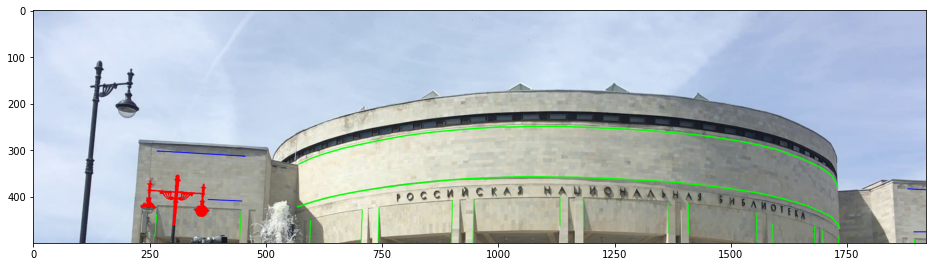

In [888]:
imshow(cv2.cvtColor(img_source_mask[:500, :], cv2.COLOR_RGB2BGR))

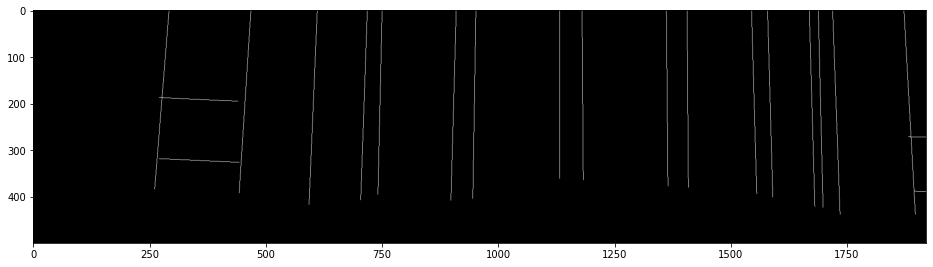

In [291]:
tmp = np.zeros(img_source_mask.shape, dtype='uint8')
for i, line in enumerate(lines_h['left']):
    for point in line:
        tmp[int(point[0]), int(point[1])] = 255
for i, line in enumerate(lines_h['right']):
    for point in line:
        tmp[int(point[0]), int(point[1])] = 255
for i, line in enumerate(lines_v):
    for point in line:
        tmp[int(point[0]), int(point[1])] = 255
imshow(tmp[100:600, : ])

## Поиск кривых (выделены зеленым цветом)

In [823]:
def add_curce_points_to_curves(curves, points: list, col, shift=1):
    for row in points:
        curves_filtered = list(filter(lambda l: l[-1][0] -2 <= row <= l[-1][0] + 2, curves))

        if not curves_filtered:
            curves.append([(row, col)])
        else:
            if len(curves_filtered) > 1:  # Линии на одних и тех же строках
                raise Exception('...')
            
            curve = curves_filtered[0]
            if curve[-1][1] - col < 2:
                curve.append((row, col))

    curves_out = []
    for c in curves:
        right_point = c[-1]  # столбец последней (наиправейшей) точки
        if col - right_point[1] < 5 or len(c) > 5:
            curves_out.append(c)
#         elif col > 570:
#             print('remove_curve', col, c)
    
    return curves_out

def find_horisontal_curces(img_source_mask, color='green'):
    green_mask = (img_source_mask[:, :, 1] > 240) & (img_source_mask[:, :, 0] < 10)
    green_mask = green_mask.astype('uint8') * 255

    curves = []  # (border [left, right], line)

    for i, col in enumerate(range(0, green_mask.shape[1])):
        img_col = green_mask[:, col]
        
        splits = lines_get_splits(img_col, threshold=threshold)  # returns rows
        if splits is not None:
            curves = add_curce_points_to_curves(curves, splits, col=col)
    
    curves = add_curce_points_to_curves(curves, points=[], col=green_mask.shape[1] - 1)

    assert len(curves) == 2, f'Найдено неправильное кол-во {len(curves)} горизонтальных кривых, с цветом маски: "{color}"'
    index_top = 0 if curves[0][0][0] < curves[1][0][0] else 1
    return {'top': np.array(curves[index_top]), 'bottom': np.array(curves[1 - index_top])}
            
curves = find_horisontal_curces(img_source_mask)

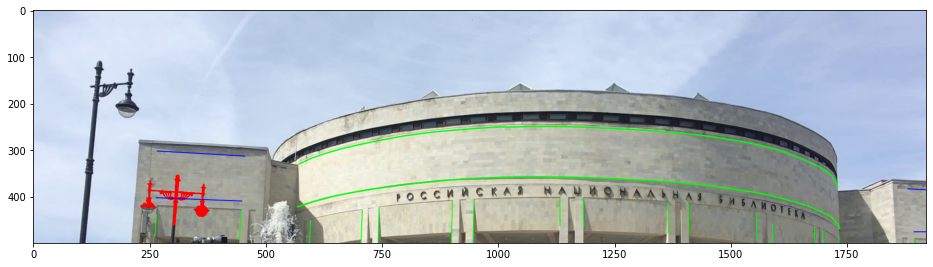

In [824]:
imshow(cv2.cvtColor(img_source_mask[:500, :], cv2.COLOR_RGB2BGR))

In [1006]:
def intersect2d(l1, l2, name=None):
    l1_set = set(map(tuple, l1))
    l2_set = set(map(tuple, l2))
    intersect = l1_set & l2_set
    if len(intersect) == 1:
        p = list(intersect)[0]
        
        l1_index = np.where((l1[:, 0] == p[0]) & (l1[:, 1] == p[1]))[0]
        l2_index = np.where((l2[:, 0] == p[0]) & (l2[:, 1] == p[1]))[0]
        
        return p, l1_index[0], l2_index[0]
    else:
        raise Exception(f'The intersect is not single: {len(intersect)}')

def create_middle_boxes(lines_v, curves):
    boxes = []
    for i in range(0, len(lines_v), 2):
        print(f'Find middle box: {i}')
        l1, l2 = lines_v[i], lines_v[i + 1]
        
        p, l_lt_index, l_tl_index = intersect2d(l1, curves['top'], name='left-top')
        p, l_rt_index, l_tr_index = intersect2d(l2, curves['top'], name='right-top')
        
        p, l_lb_index, l_bl_index = intersect2d(l1, curves['bottom'], name='left-bottom')
        p, l_rb_index, l_br_index = intersect2d(l2, curves['bottom'], name='right-bottom')

        box = {
            'top': curves['top'][l_tl_index: l_tr_index + 1],  # top
            'right': l2[l_rt_index: l_rb_index + 1],  # right
            'bottom': curves['bottom'][l_bl_index: l_br_index + 1],  # bottom
            'left': l1[l_lt_index: l_lb_index + 1],  # left
        }
        
        boxes.append(box)

    return boxes

def create_left_box(lines_v, lines_h):
    print('create_left_box')
    line_vl, line_vr = lines_v[0], lines_v[1]
    left, right = line_vl[:, 1].min(), line_vr[:, 1].max()
    
    line_top = interp(lines_h[0][:, [1, 0]], min_p=left, max_p=right + 1)[:, [1, 0]]
    line_bottom = interp(lines_h[1][:, [1, 0]], min_p=left, max_p=right + 1)[:, [1, 0]]
    
    return create_middle_boxes(lines_v, {'top': line_top, 'bottom': line_bottom})[0]

def create_right_box(lines_v, lines_h):
    if len(lines_v) == 0:
        return []
    
    if len(lines_v) == 1:
        rows = np.arange(lines_h[0][-1, 0], lines_h[1][-1, 0] + 1)
        cols = np.array([max(lines_h[0][:, 1].max(), lines_h[1][:, 1].max())] * rows.size)
        
        lines_v.append(np.vstack((rows, cols)).T)

    return create_left_box(lines_v, lines_h)

    line_left, line_right = lines_v[0], None if len(lines_v) == 1 else lines_v[0]

def create_boxes(img_source_mask, left=True):
    curves = find_horisontal_curces(img_source_mask)
    lines_h = find_horisontal_lines(img_source_mask)
    lines_v = find_vertical_lines(img_source_mask)
    
    left_box = create_left_box(lines_v[:2], lines_h['left'])
    middle_boxes = create_middle_boxes(lines_v[2:-1], curves)  # Возвращает 7 центральных рамок
    right_box = create_right_box(lines_v[16:], lines_h['right'])

    return {'left': left_box, 'middle': middle_boxes, 'right': right_box}

boxes = create_boxes(img_source_mask)

create_left_box
Find middle box: 0
Find middle box: 0
Find middle box: 2
Find middle box: 4
Find middle box: 6
Find middle box: 8
Find middle box: 10
Find middle box: 12
create_left_box
Find middle box: 0


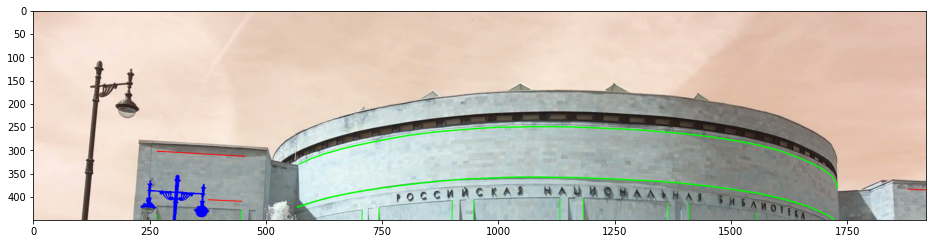

In [878]:
imshow(img_source_mask[:450])

## Вставка изображения в библиотеку

In [982]:
def calc_mask(pic, red_mask):
    mask = np.ones((pic.shape[0], pic.shape[1])).astype(bool)

    mask[red_mask] = False
    mask[(pic == [0, 0, 0]).all(axis=2)] = False
    
    return mask

def insert_pic(img, pic, shift):
    red_mask = (img_source_mask[:, :, 2] > 240) & (img_source_mask[:, :, 0] < 10)
    red_mask_path = red_mask[shift[0]: shift[0] + pic.shape[0], shift[1]: shift[1] + pic.shape[1]]
    mask = ~calc_mask(pic, red_mask_path)
    
    img_path = img[shift[0]: shift[0] + pic.shape[0], shift[1]: shift[1] + pic.shape[1], :]
    pic[mask] = img_path[mask]
    
    delta = 5
    pic[:delta, :] = ((pic[:delta, :].astype('int32') + img_path[:delta, :].astype('int32')) / 2).astype('uint8')
    pic[-delta:, :] = ((pic[-delta:, :].astype('int32') + img_path[-delta:, :].astype('int32')) / 2).astype('uint8')
    
    img[shift[0]: shift[0] + pic.shape[0], shift[1]: shift[1] + pic.shape[1], :] = pic
    
    return img

## Функции преобразования изображений

In [1012]:
def matrix_for_perspective_transform(pic, box: dict, shift: tuple):
    h, w, _ = pic.shape
    delta = 30
    
    src = np.array([[0, 0], [0, w], [h, w], [h, 0]], dtype='float32')
    src += delta
    
    dst = np.array([
        [box['left'][:, 0].min() - shift[0], box['top'][:, 1].min() - shift[1]],
        [box['right'][:, 0].min() - shift[0], box['top'][:, 1].max() - shift[1]],
        [box['right'][:, 0].max() - shift[0], box['bottom'][:, 1].max() - shift[1]],
        [box['left'][:, 0].max() - shift[0], box['bottom'][:, 1].min() - shift[1]],
    ], dtype='float32')
    dst += delta
    
    pic_in = np.zeros((h + delta * 2, w + delta * 2, 3), dtype='uint8')
    pic_in[delta: h + delta, delta: w + delta] = pic

    return cv2.getPerspectiveTransform(src[:, [1, 0]], dst[:, [1, 0]]), pic_in
    
    
def affine_transform(pic, curve_top, curve_bottom):
    height, width, _ = pic.shape
    width_max = max(curve_top.shape[0], curve_bottom.shape[0])
    
    if curve_top.shape[0] < width_max:
        curve_top = np.vstack((curve_top, curve_top[-(width_max - curve_top.shape[0]):]))
    
    if curve_bottom.shape[0] < width_max:
        curve_bottom = np.vstack((curve_bottom, [curve_bottom[-(width_max - curve_bottom.shape[0])]]))

    shift = 0#np.abs(curve_top[:, 0]).max()  # Зачем он нужен?
    
    cols = np.repeat(np.arange(width_max), 2)
    
    src_rows = np.vstack((np.zeros(width_max) + shift, np.full(width_max, fill_value=height) + shift))
    src = np.vstack((cols, src_rows.T.flat)).T  # col, row

    dst_rows = np.vstack((curve_top[:, 0] + shift, curve_bottom[:, 0] + shift))
    dst = np.vstack((cols, dst_rows.T.flat)).T
    
    pic_copy = np.zeros((height + shift, width, 3), dtype='uint8')
    pic_copy[shift:] = pic
    
    tform = transform.PiecewiseAffineTransform()
    tform.estimate(src, dst)
    
    out_h, out_w, _ = pic.shape
    out = transform.warp(pic_copy, tform.inverse, clip=False, mode='constant', cval=0,
                         output_shape=(out_h + 100, out_w))

    return util.img_as_ubyte(out), shift
    
def insert_left_pic(img, pic, box, to_resize=True, linear=True):
    pic_h, pic_w, _ = pic.shape
    box_h, box_w = box['left'][-1, 0] - box['left'][0, 0], box['bottom'][-1, 1] - box['bottom'][0, 1]

    if to_resize:
        delta = max(pic_h / box_h, pic_w / box_w)
        pic_resized = cv2.resize(pic, (int(pic_w / delta), int(pic_h / delta)))
    else:
        pic_resized = pic
    
#     if pic_w / box_w > pic_h / box_h: # Ширина больше, то есть ширина 1, высота < 1
#         shift[0] += pic.shape[0] - int(pic_resized.shape[0] * delta)
#     else:
#         shift[1] += pic.shape[1] - int(pic_resized.shape[1] * delta)
#     print('shift after', shift)

    if linear:
        shift = [box['left'][:, 0].min(), box['left'][:, 1].min()]
        
        M, pic_in = matrix_for_perspective_transform(pic_resized, box=box, shift=shift)
        warped = cv2.warpPerspective(pic_in, M, (pic_in.shape[1] + 100, pic_in.shape[0] + 200))
    else:
        top, left = box['top'][:, 0].min(), box['left'][:, 1].min()
        pic_curve_top = box['top'] - np.array([top, left])
        pic_curve_bottom = box['bottom'] - np.array([top, left])

        warped, _ = affine_transform(pic_resized, pic_curve_top, pic_curve_bottom)

    warped = warped[:, ~(warped == [0, 0, 0]).all(axis=2).all(axis=0)]
    warped = warped[~(warped == [0, 0, 0]).all(axis=2).all(axis=1), :]
    
    shift = [
        min(box['left'][:, 0].min(), box['right'][:, 0].min()),
        box['left'][:, 1].min() + int((box_w - warped.shape[1]) / 2)
    ]
    img = insert_pic(img, warped, shift)
    
    return img

In [1021]:
def insert_right_pic(img, pic, box):
    pic_h, pic_w, _ = pic.shape
    box_h, box_w = box['left'][-1, 0] - box['left'][0, 0], box['bottom'][-1, 1] - box['bottom'][0, 1]
    
    if box_w < box_h:
        pic = pic[:, :int(pic_w * (box_w / box_h))]

    delta = max(pic_h / box_h, pic_w / box_w)
    pic_resized = cv2.resize(pic, (int(pic_w / delta), int(pic_h / delta)))
#     print(box)
    return insert_left_pic(img, pic_resized, box, to_resize=False, linear=True)

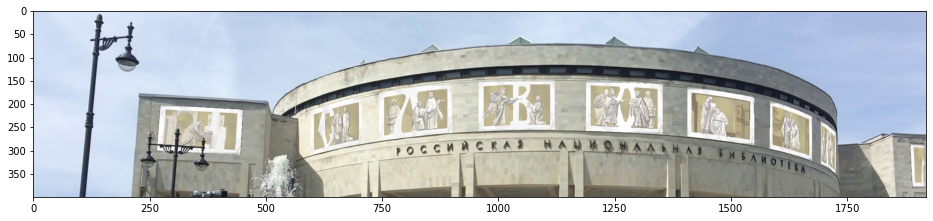

In [1023]:
img_work = img_source.copy()

img_work = insert_left_pic(img_work, input_images[0], box=boxes['left'], linear=True)
img_work = insert_right_pic(img_work, input_images[-1], box=boxes['right'])
for i, (pic, box) in enumerate(zip(input_images[1:-1], boxes['middle'])):
#     if i != 2: continue
    img_work = insert_left_pic(img_work, pic, box=box, linear=False)
#     break


# plt.imsave('out.png', cv2.cvtColor(img_work, cv2.COLOR_RGB2BGR))
imshow(cv2.cvtColor(img_work[100:500, :], cv2.COLOR_RGB2BGR))

In [653]:
curves = find_curves(img_source_mask)

img_work = img_source.copy()

for i, (points, pic) in enumerate(zip(points_list, input_images[:7])):
    if i == 0: continue
    left, right = points[0][0], points[1][0]
    img_work = insert_pic(img_work, pic, border=(left, right), curves=curves)
    # Деформировать для первого и последнего изображения не надо
#     dst, paste_border = transform(pic, np.array(points), curves, to_warp=i in {0, 8})
#     points_shifted = points - np.array([paste_border[-1], paste_border[0]])
    
#     img_work = paste_img(img_work, curves, dst, paste_border, frame_transformed=points_shifted)
#     break

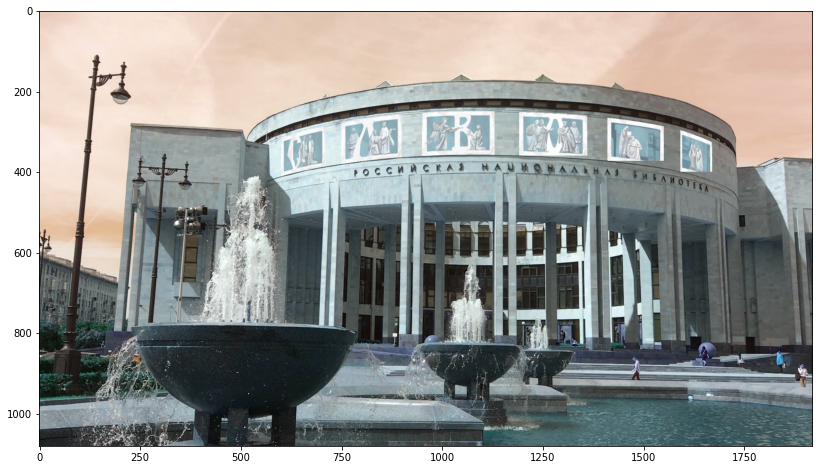

In [654]:
_, ax = plt.subplots(1, 1, figsize=(14, 8))
ax.imshow(img_work)
plt.imsave('out.png', img_work)

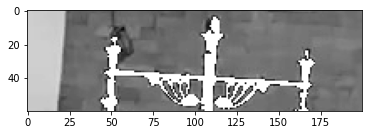

In [199]:
gray = cv2.cvtColor(img_source[350: 410, 200: 400], cv2.COLOR_BGR2GRAY)
gray[:, :][gray[:, :] < 90] = 255

plt.imshow(gray, cmap='gray')